# Detection End to End & Video Demo

This notebook includes code to run the full detection of bib numbers starting with a complete image.  This includes the following:
- Detection of the bib bounding box using the bib detection model which is then passed to the digit detector.  
- Inside the bib bounding box, detected digits are put in order from left to right based on their individual bounding boxes.  

This process is run against set3 of the RBNR dataset which was not used to train either model. The outputed bib numbers are compared against the true values provided in the dataset and compliled into a list.  Final conclusions are drawn from this validation. Lastly, a video is annotated with the detections & played directly in the notebook.

In [1]:
#Mount google drive with training and testing data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install --upgrade opencv-python

     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Import Functions & Libraries
---

In [3]:
%cp "/content/drive/MyDrive/bib-project/clean code/utils.py" /content
import utils as ut

In [4]:
import cv2 as cv
import numpy as np
import scipy.io as sio
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [5]:
# Bib detection model config
bd_configPath = '/content/drive/MyDrive/bib-project/RBNR/custom-yolov4-tiny-detector.cfg'
bd_weightsPath = '/content/drive/MyDrive/bib-project/RBNR/custom-yolov4-tiny-detector_best.weights'
bd_classes = ['bib']

# Number reader config
nr_configPath = '/content/drive/MyDrive/bib-project/SVHN/custom-yolov4-tiny-detector.cfg'
nr_weightsPath = '/content/drive/MyDrive/bib-project/SVHN/custom-yolov4-tiny-detector_best.weights'
nr_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# True bounding box color
true_color = [66, 245, 108]
# Pred Bib bounding box color
color = [66, 245, 108]

### Predict

In [6]:
# set input and output info for detections
%mkdir /usr/validation/
%mkdir /usr/validation/test
%mkdir /usr/validation/Full
%cp /content/drive/MyDrive/bib-project/RBNR/datasets/set3_org/* /usr/validation/test -r 
images_path = '/usr/validation/test/'
images = [file for file in os.listdir(images_path) if file[-3:]=='JPG']

output_path = '/usr/validation/Full/'

In [7]:
#check for existing bib_numbers.txt and remove if exists
if os.path.exists(output_path + 'bib_numbers.txt'):
    os.remove(output_path + 'bib_numbers.txt')

#check for existing preds.txt and remove if exists
if os.path.exists(output_path + 'preds.txt'):
    os.remove(output_path + 'preds.txt')

In [8]:
def annotate(img, annot, color):
    """
    Add bib numbers and bib bounding boxes to an image
    
    Args
        img (numpy array): image array of original from openCV .imread
        annot (list): list of bib numbers and bounding boxes in the 
            form [[<bib number>, [x, y, width, height]]]
        color (array): RGB color array for annotation color
        
    Returns
        Annotated image as numpy array
    """
    
    # draw bouding box on original image
    (x, y, w, h) = annot[1]
    annot_img = cv.rectangle(img,(x,y),(x+w,y+h),color,5)
    # add bib number to original image
    rbn = annot[0]
    cv.putText(annot_img, str(rbn), (x, y - 25), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    return annot_img

In [9]:
# run detections on all images in input directory
for image in images:
    img = cv.imread(images_path + image)
    
    # add true annotations
    true_values = ut.get_true_annot(image, images_path, output_path)
    for value in true_values:
        annot_img = annotate(img, value, true_color)
    
    # make predictions
    output = ut.get_rbns(img, bd_configPath, bd_weightsPath,bd_classes,nr_configPath,nr_weightsPath,nr_classes)
    
    # add predicted annotations and save prediction to file
    if output != None:
        rbn_file = open(output_path + 'preds.txt', 'a')
        
        for detection in output:
            annot_img = ut.annotate(annot_img, detection, color)
            rbn_file.writelines(f"{image},{detection[0]}\n")
            
        rbn_file.close()
        
    # save annotated image to file
    cv.imwrite(output_path + image[:-4] + 'annot' + '.JPG', annot_img)

## Validate

In [10]:
true_df = pd.read_csv('/usr/validation/Full/bib_numbers.txt', delimiter=',', 
                      index_col=0, names=['image', 'rbn'])
true_df.head()

,rbn
image,
set3_55.JPG,2331
set3_55.JPG,4624
set3_02.JPG,3855
set3_02.JPG,3236
set3_02.JPG,3482


In [11]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, set3_55.JPG to set3_28.JPG
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   rbn     113 non-null    int64
dtypes: int64(1)
memory usage: 1.8+ KB


In [12]:
pred_df = pd.read_csv('/usr/validation/Full/preds.txt', delimiter=',', 
                      index_col=0, names=['image', 'pred_rbn'])
pred_df.head()

,pred_rbn
image,
set3_55.JPG,233
set3_55.JPG,4624
set3_25.JPG,2564
set3_25.JPG,3558
set3_25.JPG,3717


In [13]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, set3_55.JPG to set3_28.JPG
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   pred_rbn  124 non-null    int64
dtypes: int64(1)
memory usage: 1.9+ KB


In [14]:
all_df = pd.merge(true_df, pred_df, on='image', how='left')

In [15]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, set3_55.JPG to set3_28.JPG
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rbn       302 non-null    int64  
 1   pred_rbn  298 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.1+ KB


#### Accurate Predictions

In [16]:
all_df.loc[all_df['rbn'] == all_df['pred_rbn']]

,rbn,pred_rbn
image,,
set3_55.JPG,4624,4624.0
set3_25.JPG,3717,3717.0
set3_25.JPG,2564,2564.0
set3_25.JPG,3558,3558.0
set3_47.JPG,3355,3355.0
...,...,...
set3_44.JPG,3286,3286.0
set3_44.JPG,3457,3457.0
set3_56.JPG,2244,2244.0


#### Inaccurate Predictions

In [17]:
all_df.loc[all_df['rbn'] != all_df['pred_rbn']]

,rbn,pred_rbn
image,,
set3_55.JPG,2331,233.0
set3_55.JPG,2331,4624.0
set3_55.JPG,4624,233.0
set3_02.JPG,3855,NaN
set3_02.JPG,3236,NaN
...,...,...
set3_56.JPG,2244,2520.0
set3_56.JPG,1334,2244.0
set3_56.JPG,1334,334.0


#### Accuracy

In [18]:
true_positives = len(all_df.loc[all_df['rbn'] == all_df['pred_rbn']])
total = len(true_df)

true_positives / total

0.6194690265486725

## Conclusions
---

As can be seen in the image below, the end to end detector has trouble with the shape of the numeral 1 in this dataset.  Predictions are in pink and provided annotations are in green.  This style of the numeral 1 did not occur in the other sets that were used for training.  Further training on larger datasets of RBN's will hopefully overcome this.


In [19]:
%cp /usr/validation/Full /content/drive/MyDrive/bib-project/RBNR -r

## Demo
---

### Image Detection Demo

In [20]:
# image for prediction
img_path = '/usr/validation/test/set3_38.JPG'
img = cv.imread(img_path)

In [21]:
# Make predictions
start = time.time()
output = ut.get_rbns(img,bd_configPath, bd_weightsPath,bd_classes,nr_configPath,nr_weightsPath,nr_classes)
end = time.time()

print(f'Pred time: {round(end - start, 2)} seconds')

Pred time: 0.22 seconds


In [22]:
for detection in output:
    img = annotate(img, detection, color)

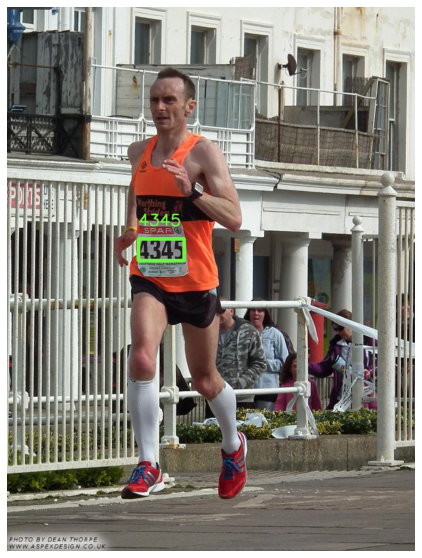

In [23]:
# Display image with predictions
img_h, img_w = img.shape[:2]
resized_img = cv.resize(img, (3*img_w, 3*img_h), interpolation=cv.INTER_CUBIC)
RGB_im = cv.cvtColor(resized_img, cv.COLOR_BGR2RGB)

fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(RGB_im);

### Video And Live Stream Detection Demo




In [ ]:
video_capture = cv.VideoCapture()
if video_capture.open('/content/drive/MyDrive/bib-project/VIDEO0433.mp4'):
  width, height = int(video_capture.get(cv.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv.CAP_PROP_FPS)
  
  !rm -f output_marathon.mp4 output_marathon.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv.VideoWriter("output_marathon.avi", cv.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
  
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break
      
    output = ut.get_rbns(frame,bd_configPath, bd_weightsPath,bd_classes,nr_configPath,nr_weightsPath,nr_classes)

    if output != None:
      for detection in output:
          frame = annotate(frame,detection,color)

    video_writer.write(frame)
  
     
  video_capture.release()
  video_writer.release()
  
  # convert AVI to MP4
  !ffmpeg -y -loglevel info -i output_marathon.avi output_marathon.mp4
else:
  print("can't open the given input video file!")

In [25]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('/content/output_marathon.mp4', width=960, height=720)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
%cp /content/output_marathon.mp4 /content/drive/MyDrive/bib-project